## GROUP 6 MOVIE ANALYSIS

Group Name : Group 6

Student pace: Full time Hybrid

Instructor name:Diana Mongina


## BUSINESS PROBLEM

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Objectives

To find the genres that generates high income 

To find which movies performs best 

To determine whether movies highly rated generated higher revenue

To find the effect of production budget on profits

To find if the release month  affects the rating



## Data Understanding

In this section, we explore the raw dataset to understand its structure, data types, and any potential duplicates or null values before performing analysis.

### Import Required Libraries

In [52]:
# Importing libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import sqlite3
from pandasql import sqldf
from statsmodels.formula.api import ols

#### Connect to SQLite Database and Explore Tables
#### We'll connect to the IMDb database and examine the available tables.

In [53]:
# SQLite connection.
conn=sqlite3.connect('./datasets/im.db')
query='''
SELECT *
    FROM sqlite_master;
'''
pd.read_sql(query,conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


#### Join Movie Basics and Ratings Tables.
#### Combining these tables gives us a comprehensive view of movie information alongside their ratings.

In [54]:
# Joining of Tables
query2='''
SELECT *
    FROM movie_basics
    JOIN movie_ratings
    USING(movie_id);
'''
movie_basics_and_ratings=pd.read_sql(query2,conn)
movie_basics_and_ratings.dropna(inplace=True)
movie_basics_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   primary_title    65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


### Load Movie Budget Data


In [55]:
# Loading the movie budgets csv file.
movie_budgets = pd.read_csv('./datasets/tn.movie_budgets.csv', index_col=0)
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


#### The dataset above contains financial information including production budgets and box office revenues

In [56]:
# displays the first 5 rows of the movie_budgets dataframe
movie_budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Cleaning Financial Columns
### Remove currency symbols and convert financial columns to numeric types for analysis.

In [57]:
# Replacing the $ and , characters and converting the columns to int64 and release_date to datetime.
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.production_budget = movie_budgets.production_budget.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.domestic_gross = movie_budgets.domestic_gross.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.release_date = pd.to_datetime(movie_budgets.release_date)
print(movie_budgets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 271.0+ KB
None


### Merge All Datasets
### Joining movie details with budget and revenue data creates our final analysis dataset.

In [58]:
# Merging datasets.
pysqldf=lambda q: sqldf(q,globals())
query3='''
SELECT *
    FROM movie_basics_and_ratings AS mbr
    JOIN movie_budgets
    ON mbr.primary_title=movie_budgets.movie;
'''
movie_details_and_revenue=pysqldf(query3)
movie_details_and_revenue.release_date = pd.to_datetime(movie_details_and_revenue.release_date)
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
dtypes: datet

## Data Analysis

In this section, we analyze key aspects of the dataset, including profitability, release patterns, ratings, and popularity. 

The goal is to uncover meaningful insights from the movie data through calculations and visualizations.

### Top 10 Highest-Grossing Genres
### Identifying which genre combinations generate the most revenue on average.

In [59]:
# Top 10 genres ordered by domestic and worldwide gross.
top_10_genres=movie_details_and_revenue.groupby('genres')[['production_budget','domestic_gross','worldwide_gross']].mean().sort_values(by=['domestic_gross','worldwide_gross'],ascending=False).head(10)
top_10_genres

,production_budget,domestic_gross,worldwide_gross
genres,,,
"Family,Fantasy,Musical",9.000000e+07,4.400357e+08,9.338154e+08
"Adventure,Drama,Sport",1.500000e+08,4.007380e+08,1.272470e+09
"Fantasy,Romance",1.500000e+08,4.007380e+08,1.272470e+09
"Action,Adventure,Sci-Fi",1.606103e+08,2.203234e+08,5.991302e+08
"Adventure,Fantasy",2.316667e+08,1.928914e+08,7.012107e+08
"Comedy,Romance,Sci-Fi",6.500000e+07,1.828051e+08,3.741051e+08
"Biography,Documentary,History",9.025000e+07,1.810211e+08,4.299082e+08
"Biography,Drama,Musical",8.400000e+07,1.743402e+08,3.866656e+08
"Adventure,Drama,Western",3.500000e+07,1.712430e+08,2.522769e+08


### Family/Fantasy/Musical and Adventure/Drama/Sport combinations yield the highest profits both domestically and worldwide.

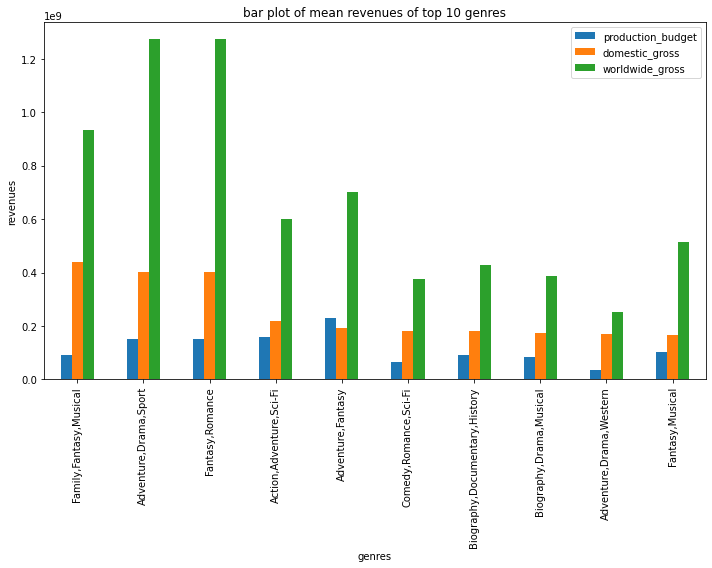

In [60]:
# Plot for the top 10 genres.
top_10_genres.plot(kind='bar',figsize=(10,8))
plt.title('bar plot of mean revenues of top 10 genres')
plt.ylabel('revenues')
plt.tight_layout();

**A mix of adventure, Drama, Sport and also a mix of Fantasy, Romance seem to yield high profit domestically and worldwide.**

### Do high budget films result in high revenue?
### We'll calculate the probability that movies earn more than their production costs.

In [61]:
# Probability of Superiority.
print(sum(x>y for x,y in zip(movie_details_and_revenue.worldwide_gross,movie_details_and_revenue.production_budget))/len(movie_details_and_revenue))
print(sum(x>y for x,y in zip(movie_details_and_revenue.domestic_gross,movie_details_and_revenue.production_budget))/len(movie_details_and_revenue))

0.6133720930232558
0.4069767441860465


##### This shows that there is a 61% chance that a movie of any genre can get a worldwide revenue greater than its production budget.
##### This shows that there is a 41% chance that a movie of any genre can get a domestic revenue greater than its production budget.

### Correlation Between Budget and Revenue.
### Examining the relationship between production investment and box office returns.

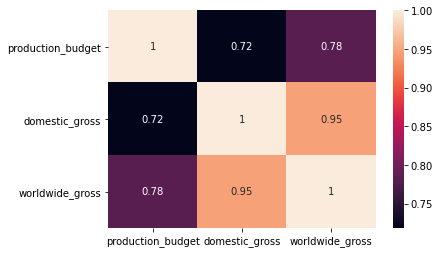

In [62]:
# correlation heatmap.
sns.heatmap(movie_details_and_revenue[['production_budget','domestic_gross','worldwide_gross']].corr(),annot=True);

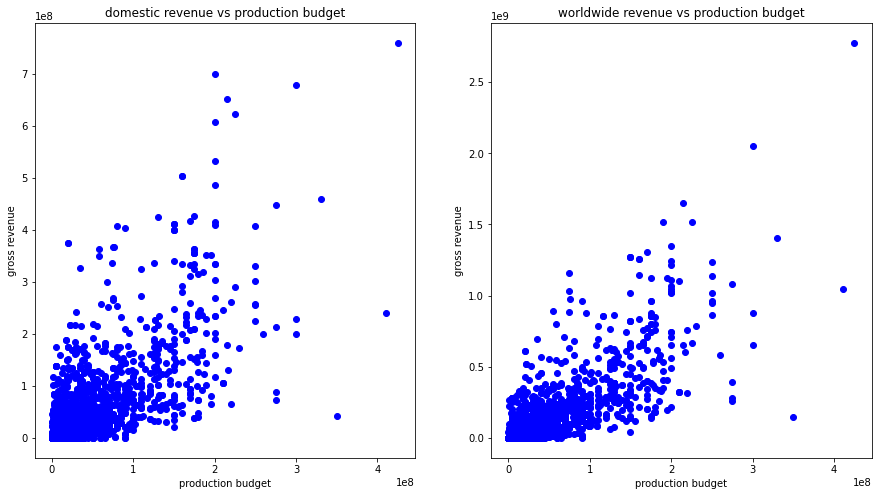

In [63]:
#Scatter plots
fig, ax = plt.subplots(ncols=2,figsize=(15,8))
ax[0].scatter(movie_details_and_revenue.production_budget,movie_details_and_revenue.domestic_gross, color='blue')
ax[1].scatter(movie_details_and_revenue.production_budget,movie_details_and_revenue.worldwide_gross, color='blue')
ax[0].set_title('domestic revenue vs production budget')
ax[1].set_title('worldwide revenue vs production budget')
for a in ax:
    a.set_xlabel('production budget')
    a.set_ylabel('gross revenue')

#### This shows that there seems to be a positive linear relationship between production budget and the revenue. The higher the budget the higher the revenue.

### Is there a relationship between movie rating and revenue?
### Testing whether highly rated movies generate significantly more revenue than lower-rated films.

H<sub>0</sub>: The mean worldwide revenue for high rated movies is less than or equal to that of low rated movies 

H<sub>1</sub>: The mean worldwide revenue for high rated movies is greater than that of low rated movies at 5% level of significance.

In [64]:
# checking the info of the final dataframe
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
dtypes: datet

In [65]:
# Checking for null values.
movie_basics_and_ratings.isnull().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
dtype: int64

In [66]:
# Top 10 average ratings with respect to domestic and worldwide gross.
movie_details_and_revenue.groupby('averagerating')[['domestic_gross','worldwide_gross']].mean().sort_values(by=['domestic_gross','worldwide_gross'],ascending=False).head(10)

,domestic_gross,worldwide_gross
averagerating,,
8.5,1.055267e+08,3.311156e+08
7.8,1.011214e+08,2.535872e+08
8.0,9.187968e+07,2.614439e+08
8.1,9.158098e+07,2.129984e+08
8.3,8.998933e+07,2.566749e+08
7.5,7.899036e+07,1.931210e+08
2.3,7.554777e+07,1.755373e+08
2.6,7.387569e+07,2.060384e+08
1.6,7.301391e+07,9.903412e+07


### T-test to compare worldwide gross between high-rated and low-rated movies.

In [67]:

high_rated=movie_details_and_revenue[movie_details_and_revenue['averagerating']>=7.0]['worldwide_gross']
low_rated=movie_details_and_revenue[movie_details_and_revenue['averagerating']<7.0]['worldwide_gross']
t_stat, p = stats.ttest_ind(high_rated,low_rated,equal_var=False)
if t_stat>0:
    p_value_one_sided=p/2
else:
    p_value_one_sided=1-(p/2)
p_value_one_sided

2.0475399338393774e-13

##### Our p-value=2.0475399338393774e-13 is less than our threshold and thus we reject the null hypothesis and conclude that we have sufficient statistical evidence to claim that the mean worldwide revenue for high rated movies is higher than the mean worldwide revenue of low rated movies at 5% level of significance.

### Is there a relationship between runtime and revenue?
### Exploring whether movie length impacts financial performance.

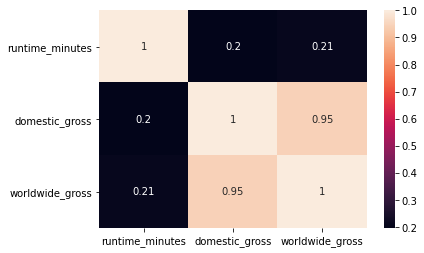

In [68]:
sns.heatmap(movie_details_and_revenue[['runtime_minutes','domestic_gross','worldwide_gross']].corr(), annot=True);

**There seems to be a very weak positive relationship between runtime in minutes and revenue.**

### Does the month of the year affect revenue?
### Analyzing seasonal patterns in box office performance.


In [69]:
query4='''
SELECT strftime("%m", release_date) AS month, AVG(worldwide_gross) AS 'average worldwide gross'
    FROM movie_details_and_revenue
    GROUP BY month;
'''
monthly_average_revenue=pysqldf(query4)
monthly_average_revenue

,month,average worldwide gross
0,01,6.833946e+07
1,02,8.925310e+07
2,03,1.259204e+08
3,04,8.945937e+07
4,05,1.579685e+08
5,06,1.733710e+08
6,07,1.394714e+08
7,08,6.419810e+07
8,09,5.323615e+07
9,10,6.253563e+07


In [70]:
month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
movie_details_and_revenue['month_released']=movie_details_and_revenue.release_date.dt.month.map(month_map)
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
 14  month_re

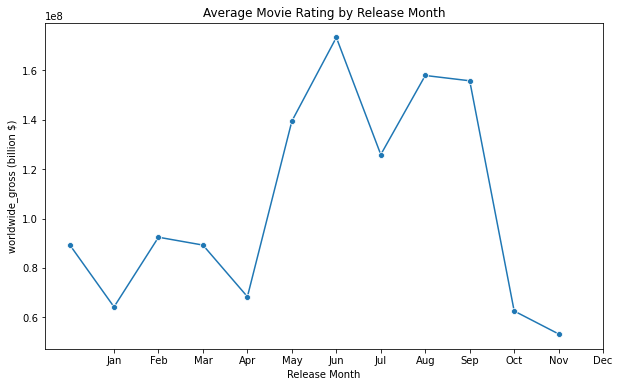

In [71]:

movie_details_and_revenue['release_month'] = movie_details_and_revenue['release_date'].dt.month # Extracting month from release_date

# Average rating per month
monthly_ratings = movie_details_and_revenue.groupby('month_released')['worldwide_gross'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_ratings.index, y=monthly_ratings.values, marker='o')
plt.title('Average Movie Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('worldwide_gross (billion $)')
plt.xticks(range(1,13), month_map.values())
plt.show()

 **Average worldwide revenue peaks around summer (Jun-Aug), indicating that films released during these months generally outperform those in other parts of the year.**

H<sub>0</sub>: month does not have a significant effect on worldwide gross 

H<sub>1</sub>: month has a significant effect on worldwide gross at 5% level of significance.

In [72]:
# Grouping worldwide gross by month.
groups = [
    movie_details_and_revenue.loc[movie_details_and_revenue['month_released'] == m, 'worldwide_gross'] for m in sorted(movie_details_and_revenue['month_released'].unique())
]
f_stat, p = f_oneway(*groups)
p

5.8301897405767244e-18

**Since our p value = 5.8301897405767244e-18 is less than our threshold we reject the null and conclude that the month has a significant impact on worldwide gross at 5% level of significance.**

In [73]:
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
 14  month_re

#### To find which movies performs best
#### Identifying the best performing films to understand what drives exceptional success.

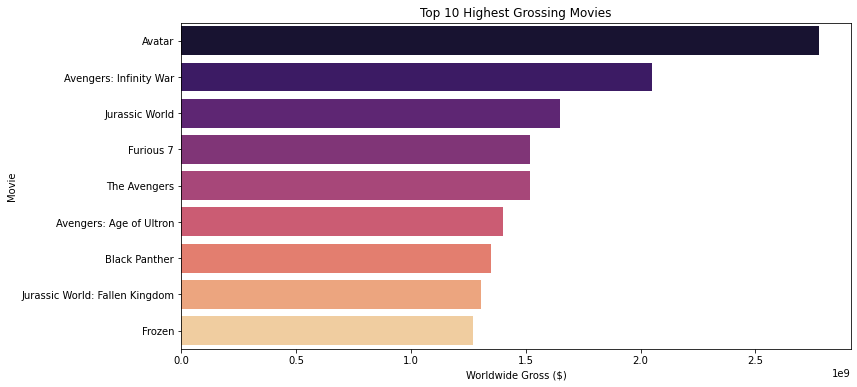

In [74]:
# Top 10 highest grossing movies.
plt.figure(figsize=(12,6))
sns.barplot(x='worldwide_gross', y='movie', data=movie_details_and_revenue.sort_values('worldwide_gross', ascending=False).head(10), palette="magma")
plt.title('Top 10 Highest Grossing Movies')
plt.xlabel('Worldwide Gross ($)')
plt.ylabel('Movie')
plt.show()

**Avatar generates the highest revenue globally earning over 2.7 billion dollars**

**Other top perfomers include avengers, jurassic world and furious 7 each surpassed 1.5 billion dollars.**

### To find if the release month  affects the rating
### Examining whether certain months produce higher-quality films based on audience ratings.


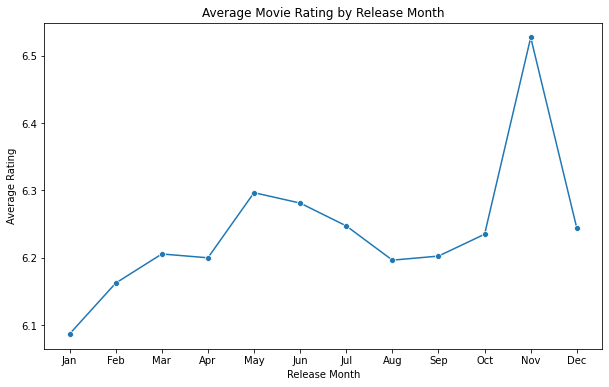

In [75]:

movie_details_and_revenue['month_released'] = movie_details_and_revenue['release_date'].dt.month

# Average rating per month
monthly_ratings = movie_details_and_revenue.groupby('month_released')['averagerating'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_ratings.index, y=monthly_ratings.values, marker='o')
plt.title('Average Movie Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Rating')
plt.xticks(range(1,13)
           , ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

**It's clear that movies released during certain month tend to achieve higher rating than others. This could be because studios release well promoted audience friendly films towards the middle of the year.**

In [76]:
movie_details_and_revenue.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
 14  month_re

**RECOMMENDATION**

**1. Invest More in Quality Production — Ratings Strongly Correlate with Revenue**

Data shows that higher-rated movies (7.5–8.5) consistently generate higher average worldwide gross.


This suggests that audience satisfaction and critical reception directly translate into box office success.


**Business Implication:**

 Focus resources on strong scripts, high production standards, and casting quality rather than chasing trends.
 Building a reputation for high-quality films can improve both short-term revenue and long-term brand equity.

**2.  Budget Strategically — Bigger Isn’t Always Better**

The data indicates that while larger budgets can lead to higher revenue, the relationship isn’t perfectly proportional.


Some medium-budget films achieved surprisingly strong performance, likely due to effective storytelling or niche appeal.


**Business Implication:**

 Adopt a tiered investment strategy:

Maintain a balanced portfolio of a few high-budget blockbusters and multiple mid-tier films with strong scripts.


Avoid excessive spending without evidence of market demand or proven audience engagement.



**3. Optimize Release Timing — Seasonality Matters**

Preliminary analysis of month_released suggests certain months outperform others, particularly March-May and December.


Historically, these align with holiday and leisure periods when audiences are more available.


**Business Implication:**

 Plan major releases during high-demand seasons (e.g., June, July, December).

 Use off-peak months (like February or September) for lower-budget or niche films to reduce competition and maximize visibility.

**4.  Focus on Genre Mix That Drives High Income**

Genre-level insights indicate that action, adventure, and fantasy films tend to produce the highest revenues.


However, dramas and thrillers often achieve higher ratings, showing artistic or critical success.


**Business Implication:**

Maintain a genre diversification strategy — balance commercial genres (for revenue) with critically acclaimed genres (for brand reputation).


Consider hybrid storytelling (e.g., dramatic thrillers, action-dramas) to capture both critical and audience interest.


In [77]:
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
 14  month_re